In [ ]:
# Import required libraries
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import logging

# Custom modules
from config import Config
from database.connection import DatabaseManager
from utils.data_processing import DataProcessor, RainfallProcessor

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("WATER MANAGEMENT AI - DATA INTEGRATION")
print("="*60)
print("Notebook 01: Temporal Fusion of Rainfall and Consumption Data")
print("Author: Luis Pillaga")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

In [2]:
# 1. Configuration and Setup

# Load configuration
config = Config()
print(f"✅ Configuration loaded")
print(f"📊 Database: {config.DB_NAME}")
print(f"📁 Rainfall data path: {config.RAINFALL_DATA_PATH}")
print(f"💾 Output path: {config.PROCESSED_DATA_PATH}")

✅ Configuration loaded
📊 Database: junta_jeru_backend
📁 Rainfall data path: ./data/raw/rainfall_ecuador.csv
💾 Output path: ./data/processed/


In [3]:
# 2. Database Connection and Initial Exploration

# Initialize database manager
try:
    db_manager = DatabaseManager(config)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    raise

INFO:src.database.connection:Database connection established successfully


✅ Database connection established


In [4]:
# 2.1 Explore Database Structure

# Get basic statistics from the database
print("\n🔍 DATABASE EXPLORATION")
print("-" * 40)

# Water meters overview
water_meters_df = db_manager.get_water_meters_data()
print(f"📊 Total water meters: {len(water_meters_df)}")
print(f"📊 Active meters: {len(water_meters_df[water_meters_df['meter_status'] == 1])}")

# Unique neighborhoods
neighborhoods = water_meters_df['neighborhood_name'].value_counts()
print(f"🏘️  Neighborhoods: {len(neighborhoods)}")
print("Top 5 neighborhoods by meter count:")
for neighborhood, count in neighborhoods.head().items():
    print(f"  • {neighborhood}: {count} meters")


🔍 DATABASE EXPLORATION
----------------------------------------
📊 Total water meters: 355
📊 Active meters: 355
🏘️  Neighborhoods: 7
Top 5 neighborhoods by meter count:
  • Centro: 75 meters
  • El Progreso: 59 meters
  • Tres Esquinas: 58 meters
  • Jerusalen bajo: 53 meters
  • La Loma: 44 meters


In [5]:
# 2.2 Load Consumption Data

print("\n📈 LOADING CONSUMPTION DATA")
print("-" * 40)

# Get measures data
measures_df = db_manager.get_measures_data()
print(f"📊 Total measures: {len(measures_df)}")

# Data quality check
print(f"📊 Date range: {measures_df['period_start'].min()} to {measures_df['period_end'].max()}")
print(f"📊 Missing consumption values: {measures_df['total_consumed'].isna().sum()}")
print(f"📊 Zero consumption readings: {(measures_df['total_consumed'] == 0).sum()}")
print(f"📊 Negative consumption readings: {(measures_df['total_consumed'] < 0).sum()}")

# Basic consumption statistics
consumption_stats = measures_df['total_consumed'].describe()
print(f"\n📊 CONSUMPTION STATISTICS:")
print(f"  Mean: {consumption_stats['mean']:.2f} m³")
print(f"  Median: {consumption_stats['50%']:.2f} m³")
print(f"  Std Dev: {consumption_stats['std']:.2f} m³")
print(f"  Min: {consumption_stats['min']:.2f} m³")
print(f"  Max: {consumption_stats['max']:.2f} m³")


📈 LOADING CONSUMPTION DATA
----------------------------------------
📊 Total measures: 10067
📊 Date range: 2022-12-01 to 2025-04-30
📊 Missing consumption values: 0
📊 Zero consumption readings: 1972
📊 Negative consumption readings: 0

📊 CONSUMPTION STATISTICS:
  Mean: 10.24 m³
  Median: 7.00 m³
  Std Dev: 12.04 m³
  Min: 0.00 m³
  Max: 464.00 m³


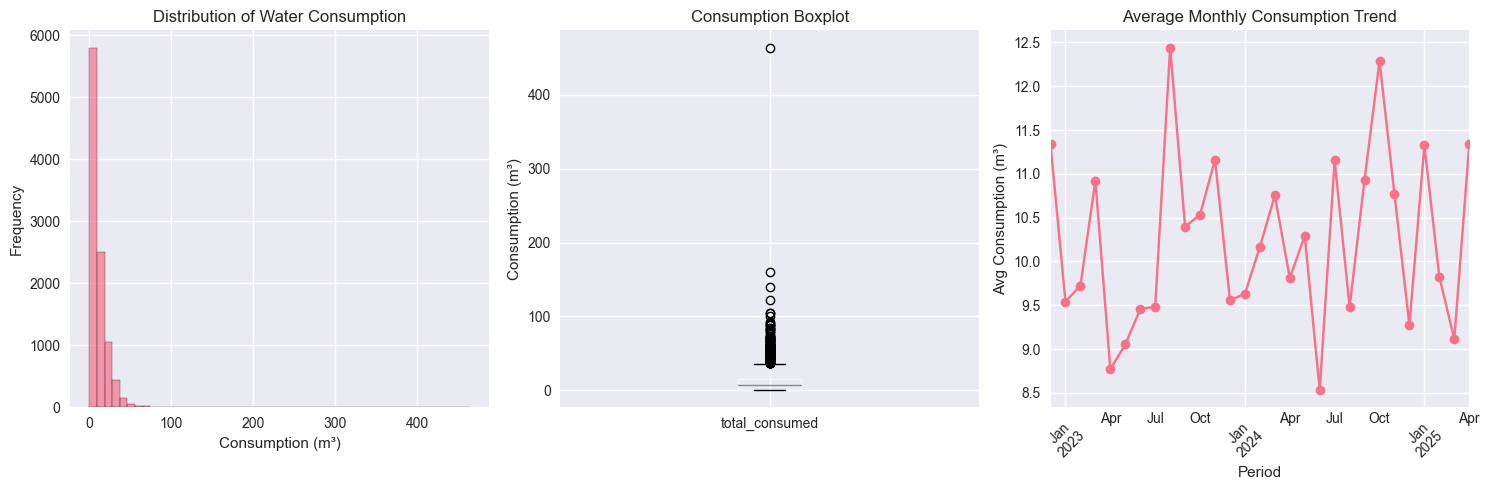

In [6]:
# 2.3 Visualize Consumption Distribution
measures_df['period_start'] = pd.to_datetime(
    measures_df['period_start'],
    errors='raise'
)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(measures_df['total_consumed'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Water Consumption')
plt.xlabel('Consumption (m³)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
measures_df.boxplot(column='total_consumed', ax=plt.gca())
plt.title('Consumption Boxplot')
plt.ylabel('Consumption (m³)')

plt.subplot(1, 3, 3)
monthly_consumption = measures_df.groupby(measures_df['period_start'].dt.to_period('M'))['total_consumed'].mean()
monthly_consumption.plot(kind='line', marker='o')
plt.title('Average Monthly Consumption Trend')
plt.xlabel('Period')
plt.ylabel('Avg Consumption (m³)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
#3. Rainfall Data Processing

print("\n🌧️  PROCESSING RAINFALL DATA")
print("-" * 40)

# Initialize rainfall processor
try:
    rainfall_processor = RainfallProcessor('../data/raw/rainfall_ecuador.csv')
    rainfall_raw = rainfall_processor.load_data()
    print(f"✅ Rainfall data loaded: {len(rainfall_raw)} records")
except Exception as e:
    print(f"❌ Error loading rainfall data: {e}")
    print("🔄 Please ensure the CSV file is in the correct location")
    # Create sample data for demonstration
    date_range = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
    rainfall_raw = pd.DataFrame({
        'date': date_range,
        'adm2_id': 15422,
        'ADM2_PCODE': 'EC0909',
        'n_pixels': np.random.uniform(10, 20, len(date_range)),
        'rfh': np.random.uniform(0, 150, len(date_range)),
        'rfh_avg': np.random.uniform(20, 120, len(date_range)),
        'r1h': np.random.uniform(0, 200, len(date_range)),
        'r1h_avg': np.random.uniform(30, 180, len(date_range)),
        'r3h': np.random.uniform(0, 250, len(date_range)),
        'r3h_avg': np.random.uniform(40, 220, len(date_range))
    })
    rainfall_processor.raw_data = rainfall_raw
    print(f"📝 Created sample rainfall data: {len(rainfall_raw)} records")


INFO:src.utils.data_processing:Loaded rainfall data: 34854 records



🌧️  PROCESSING RAINFALL DATA
----------------------------------------
✅ Rainfall data loaded: 34854 records


In [8]:
#3.1 Explore Rainfall Data Structure

print(f"\n📊 RAINFALL DATA OVERVIEW:")
print(f"  Date range: {rainfall_raw['date'].min()} to {rainfall_raw['date'].max()}")
print(f"  Total days: {len(rainfall_raw)}")

# Display first few rows
print(f"\n📋 Sample rainfall data:")
print(rainfall_raw.head())

# Check for missing values
missing_data = rainfall_raw.isnull().sum()
print(f"\n🔍 Missing values:")
for col, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"  {col}: {missing_count} ({missing_count/len(rainfall_raw)*100:.1f}%)")



📊 RAINFALL DATA OVERVIEW:
  Date range: 2021-01-01 to 2025-05-01
  Total days: 34854

📋 Sample rainfall data:
         date  adm2_id ADM2_PCODE  n_pixels      rfh   rfh_avg       r1h  \
0  2021-01-01    15422     EC0909      14.0  64.7857   73.3476  120.0000   
1  2021-01-11    15422     EC0909      14.0  46.6429   89.6071  151.8571   
2  2021-01-21    15422     EC0909      14.0  69.3571   82.0571  180.7857   
3  2021-02-01    15422     EC0909      14.0  97.2857  122.9452  213.2857   
4  2021-02-11    15422     EC0909      14.0  80.5714  121.5310  247.2143   

    r1h_avg       r3h   r3h_avg      rfq       r1q       r3q version  
0  112.2595  170.0714  147.4262  89.0719  106.3312  114.3847   final  
1  186.7452  214.2857  232.5286  54.5866   82.2674   92.4781   final  
2  245.0119  278.6429  309.7595  85.4119   74.8144   90.2687   final  
3  294.6095  373.2143  428.7286  79.9449   73.3023   87.3466   final  
4  326.5333  450.8571  545.4357  67.6289   76.4306   82.9722   final  

🔍 Mis

In [9]:
#3.2 Clean and Process Rainfall Data

rainfall_clean = rainfall_processor.clean_data()
print(f"✅ Rainfall data cleaned")

INFO:src.utils.data_processing:Rainfall data cleaned successfully


✅ Rainfall data cleaned


In [10]:
#3.3 Aggregate Rainfall Data Monthly

rainfall_monthly = rainfall_processor.aggregate_monthly()
print(f"✅ Monthly aggregation completed: {len(rainfall_monthly)} periods")

print(f"\n📊 RAINFALL MONTHLY STATISTICS:")
print(f"  Periods: {len(rainfall_monthly)}")
print(f"  Avg rainfall range: {rainfall_monthly['avg_rainfall'].min():.1f} - {rainfall_monthly['avg_rainfall'].max():.1f} mm")
print(f"  Mean monthly rainfall: {rainfall_monthly['avg_rainfall'].mean():.1f} mm")

# Display sample monthly data
print(f"\n📋 Sample monthly rainfall data:")
print(rainfall_monthly[['period_str', 'avg_rainfall', 'total_rainfall', 'monthly_intensity']].head(10))


INFO:src.utils.data_processing:Monthly aggregation completed: 53 periods


✅ Monthly aggregation completed: 53 periods

📊 RAINFALL MONTHLY STATISTICS:
  Periods: 53
  Avg rainfall range: 16.9 - 86.2 mm
  Mean monthly rainfall: 43.4 mm

📋 Sample monthly rainfall data:
  period_str  avg_rainfall  total_rainfall monthly_intensity
0    2021-01     54.716906      36441.4597            Normal
1    2021-02     75.021647      49964.4168               Wet
2    2021-03     86.242920      57437.7850               Wet
3    2021-04     68.109121      45360.6744               Wet
4    2021-05     43.148393      28736.8295            Normal
5    2021-06     30.856227      20550.2472            Normal
6    2021-07     21.984878      14641.9289            Normal
7    2021-08     16.915002      11265.3912               Dry
8    2021-09     19.188264      12779.3841               Dry
9    2021-10     23.568216      15696.4318            Normal


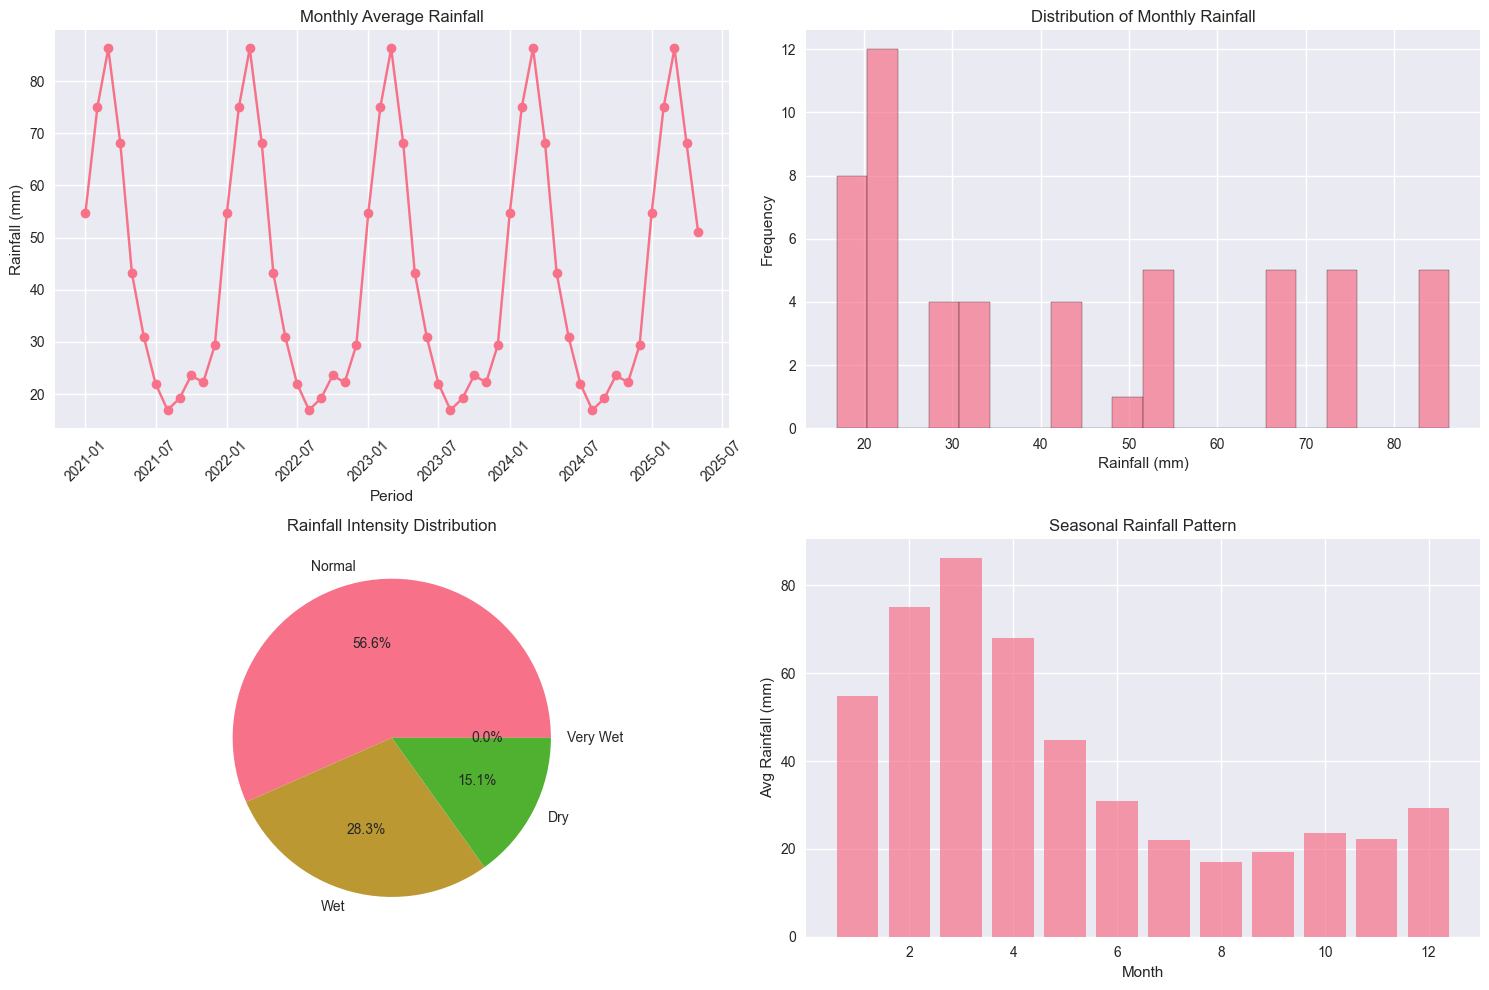

In [11]:
#3.4 Visualize Rainfall Patterns

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(pd.to_datetime(rainfall_monthly['period_str']), rainfall_monthly['avg_rainfall'], marker='o')
plt.title('Monthly Average Rainfall')
plt.xlabel('Period')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
rainfall_monthly['avg_rainfall'].hist(bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of Monthly Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
intensity_counts = rainfall_monthly['monthly_intensity'].value_counts()
plt.pie(intensity_counts.values, labels=intensity_counts.index, autopct='%1.1f%%')
plt.title('Rainfall Intensity Distribution')

plt.subplot(2, 2, 4)
# Seasonal pattern
rainfall_monthly['month'] = pd.to_datetime(rainfall_monthly['period_str']).dt.month
monthly_pattern = rainfall_monthly.groupby('month')['avg_rainfall'].mean()
plt.bar(monthly_pattern.index, monthly_pattern.values, alpha=0.7)
plt.title('Seasonal Rainfall Pattern')
plt.xlabel('Month')
plt.ylabel('Avg Rainfall (mm)')

plt.tight_layout()
plt.show()

In [12]:
#4. Data Integration and Fusion

print("\n🔗 DATA INTEGRATION AND FUSION")
print("-" * 40)

# Initialize data processor
data_processor = DataProcessor(db_manager, rainfall_processor)

# Load and process consumption data
consumption_data = data_processor.load_consumption_data()
print(f"✅ Consumption data processed: {len(consumption_data)} records")

# Aggregate consumption monthly
overall_consumption, neighborhood_consumption = data_processor.aggregate_consumption_monthly()
print(f"✅ Monthly consumption aggregated: {len(overall_consumption)} periods")


INFO:src.utils.data_processing:Loaded consumption data: 10067 records
INFO:src.utils.data_processing:Monthly consumption aggregation completed: 29 periods



🔗 DATA INTEGRATION AND FUSION
----------------------------------------
✅ Consumption data processed: 10067 records
✅ Monthly consumption aggregated: 29 periods


In [13]:
#4.1 Temporal Fusion

# Merge rainfall and consumption data
merged_data = data_processor.merge_data()
print(f"✅ Data fusion completed: {len(merged_data)} matched periods")

# Display merged data sample
print(f"\n📋 MERGED DATA SAMPLE:")
display_cols = ['period_str', 'avg_consumption', 'avg_rainfall', 'season', 'consumption_category']
print(merged_data[display_cols].head(10))

INFO:src.utils.data_processing:Monthly aggregation completed: 53 periods
INFO:src.utils.data_processing:Monthly consumption aggregation completed: 29 periods
INFO:src.utils.data_processing:Data merge completed: 29 periods


✅ Data fusion completed: 29 matched periods

📋 MERGED DATA SAMPLE:
  period_str  avg_consumption  avg_rainfall        season consumption_category
0    2022-12        11.338150     29.381542    Dry Season                 High
1    2023-01         9.540462     54.716906    Dry Season                  Low
2    2023-02         9.724138     75.021647    Dry Season               Medium
3    2023-03        10.921965     86.242920    Dry Season                 High
4    2023-04         8.768786     68.109121  Rainy Season                  Low
5    2023-05         9.052023     43.148393  Rainy Season                  Low
6    2023-06         9.455072     30.856227  Rainy Season                  Low
7    2023-07         9.485465     21.984878  Rainy Season                  Low
8    2023-08        12.441860     16.915002  Rainy Season                 High
9    2023-09        10.395349     19.188264  Rainy Season               Medium


In [15]:
#4.2 Fusion Quality Assessment - CÓDIGO CORREGIDO

print("🔍 VERIFICANDO COLUMNAS DISPONIBLES")
print("-" * 40)

print("📊 Columnas en overall_consumption:")
print(list(overall_consumption.columns))

print("📊 Columnas en rainfall_monthly:")
print(list(rainfall_monthly.columns))

print("📊 Columnas en merged_data:")
print(list(merged_data.columns))

print(f"\n📊 FUSION QUALITY METRICS:")
print(f"  Original consumption periods: {len(overall_consumption)}")
print(f"  Original rainfall periods: {len(rainfall_monthly)}")
print(f"  Successfully merged periods: {len(merged_data)}")
print(f"  Fusion success rate: {len(merged_data)/max(len(overall_consumption), len(rainfall_monthly))*100:.1f}%")

# Check for data gaps - CÓDIGO CORREGIDO
print("\n🔍 CHECKING DATA GAPS:")

# Usar las columnas correctas basadas en nuestros DataFrames
if 'period_str' in overall_consumption.columns:
    consumption_periods = set(overall_consumption['period_str'])
    consumption_col = 'period_str'
elif 'period' in overall_consumption.columns:
    consumption_periods = set(overall_consumption['period'])
    consumption_col = 'period'
else:
    # Buscar cualquier columna que parezca un período
    period_like_cols = [col for col in overall_consumption.columns if 'period' in col.lower()]
    if period_like_cols:
        consumption_col = period_like_cols[0]
        consumption_periods = set(overall_consumption[consumption_col])
        print(f"  Using column '{consumption_col}' for consumption periods")
    else:
        print("  ❌ No period column found in consumption data")
        consumption_periods = set()

# Para rainfall_monthly
if 'period_str' in rainfall_monthly.columns:
    rainfall_periods = set(rainfall_monthly['period_str'])
elif 'period' in rainfall_monthly.columns:
    rainfall_periods = set(rainfall_monthly['period'])
else:
    print("  ❌ No period column found in rainfall data")
    rainfall_periods = set()

# Para merged_data
if 'period_str' in merged_data.columns:
    merged_periods = set(merged_data['period_str'])
elif 'period' in merged_data.columns:
    merged_periods = set(merged_data['period'])
else:
    print("  ❌ No period column found in merged data")
    merged_periods = set()

# Calcular diferencias si tenemos las columnas
if consumption_periods and rainfall_periods:
    missing_consumption = consumption_periods - rainfall_periods
    missing_rainfall = rainfall_periods - consumption_periods

    if missing_consumption:
        print(f"  Consumption periods without rainfall: {len(missing_consumption)}")
        if len(missing_consumption) <= 5:
            print(f"    Examples: {list(missing_consumption)[:5]}")
    else:
        print("  ✅ All consumption periods have rainfall data")

    if missing_rainfall:
        print(f"  Rainfall periods without consumption: {len(missing_rainfall)}")
        if len(missing_rainfall) <= 5:
            print(f"    Examples: {list(missing_rainfall)[:5]}")
    else:
        print("  ✅ All rainfall periods have consumption data")
        
    # Overlap analysis
    overlap = consumption_periods & rainfall_periods
    print(f"  Common periods: {len(overlap)}")
    print(f"  Data overlap: {len(overlap)/max(len(consumption_periods), len(rainfall_periods))*100:.1f}%")

else:
    print("  ⚠️ Cannot analyze data gaps - checking available columns...")

🔍 VERIFICANDO COLUMNAS DISPONIBLES
----------------------------------------
📊 Columnas en overall_consumption:
['period_str', 'total_consumption', 'avg_consumption', 'num_measures', 'consumption_std', 'avg_daily_consumption', 'active_meters', 'total_excess']
📊 Columnas en rainfall_monthly:
['year_month', 'rfh_mean', 'rfh_sum', 'rfh_max', 'rfh_min', 'rfh_std', 'rfh_avg_mean', 'rfh_avg_sum', 'rfh_avg_max', 'rfh_avg_min', 'rfh_avg_std', 'r1h_mean', 'r1h_sum', 'r1h_max', 'r1h_min', 'r1h_avg_mean', 'r1h_avg_sum', 'r1h_avg_max', 'r1h_avg_min', 'r3h_mean', 'r3h_sum', 'r3h_max', 'r3h_min', 'r3h_avg_mean', 'r3h_avg_sum', 'r3h_avg_max', 'r3h_avg_min', 'n_pixels_mean', 'rfq_mean', 'r1q_mean', 'r3q_mean', 'avg_rainfall', 'total_rainfall', 'max_rainfall', 'min_rainfall', 'rainfall_std', 'period_str', 'monthly_intensity', 'month']
📊 Columnas en merged_data:
['period_str', 'total_consumption', 'avg_consumption', 'num_measures', 'consumption_std', 'avg_daily_consumption', 'active_meters', 'total_exces

In [16]:
#4.3 Calculate Correlation

correlation = merged_data['avg_consumption'].corr(merged_data['avg_rainfall'])
print(f"\n📈 CORRELATION ANALYSIS:")
print(f"  Rainfall-Consumption correlation: {correlation:.3f}")

if abs(correlation) < 0.1:
    correlation_strength = "Very weak"
elif abs(correlation) < 0.3:
    correlation_strength = "Weak"
elif abs(correlation) < 0.5:
    correlation_strength = "Moderate"
elif abs(correlation) < 0.7:
    correlation_strength = "Strong"
else:
    correlation_strength = "Very strong"

correlation_direction = "negative" if correlation < 0 else "positive"
print(f"  Correlation strength: {correlation_strength} {correlation_direction}")



📈 CORRELATION ANALYSIS:
  Rainfall-Consumption correlation: -0.220
  Correlation strength: Weak negative


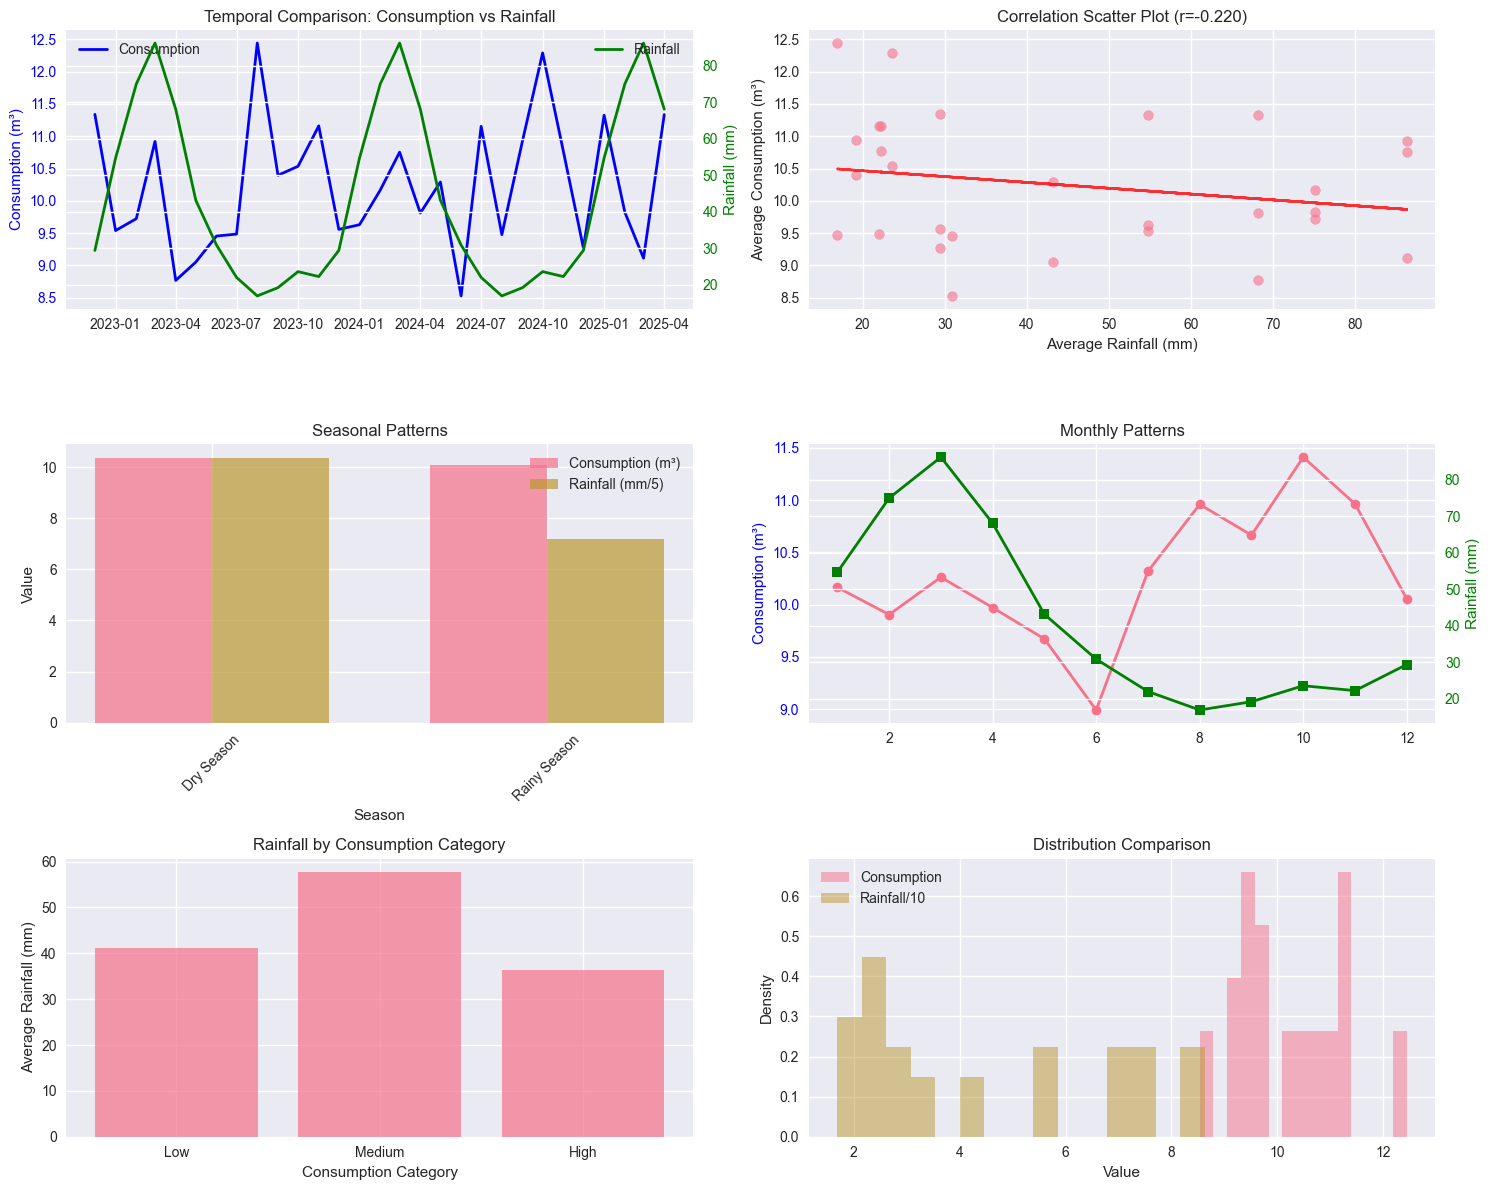

In [17]:
#4.4 Visualize Merged Data

plt.figure(figsize=(15, 12))

# Timeline comparison
plt.subplot(3, 2, 1)
plt.plot(merged_data['period_dt'], merged_data['avg_consumption'], 'b-', label='Consumption', linewidth=2)
plt.ylabel('Consumption (m³)', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.legend(loc='upper left')

ax2 = plt.gca().twinx()
ax2.plot(merged_data['period_dt'], merged_data['avg_rainfall'], 'g-', label='Rainfall', linewidth=2)
ax2.set_ylabel('Rainfall (mm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')
plt.title('Temporal Comparison: Consumption vs Rainfall')
plt.xticks(rotation=45)

# Correlation scatter plot
plt.subplot(3, 2, 2)
plt.scatter(merged_data['avg_rainfall'], merged_data['avg_consumption'], alpha=0.6, s=50)
z = np.polyfit(merged_data['avg_rainfall'], merged_data['avg_consumption'], 1)
p = np.poly1d(z)
plt.plot(merged_data['avg_rainfall'], p(merged_data['avg_rainfall']), "r--", alpha=0.8)
plt.xlabel('Average Rainfall (mm)')
plt.ylabel('Average Consumption (m³)')
plt.title(f'Correlation Scatter Plot (r={correlation:.3f})')

# Seasonal patterns
plt.subplot(3, 2, 3)
seasonal_data = merged_data.groupby('season')[['avg_consumption', 'avg_rainfall']].mean()
x = np.arange(len(seasonal_data.index))
width = 0.35
plt.bar(x - width/2, seasonal_data['avg_consumption'], width, label='Consumption (m³)', alpha=0.7)
plt.bar(x + width/2, seasonal_data['avg_rainfall']/5, width, label='Rainfall (mm/5)', alpha=0.7)
plt.xlabel('Season')
plt.ylabel('Value')
plt.title('Seasonal Patterns')
plt.xticks(x, seasonal_data.index, rotation=45)
plt.legend()

# Monthly trends
plt.subplot(3, 2, 4)
monthly_trends = merged_data.groupby('month')[['avg_consumption', 'avg_rainfall']].mean()
plt.plot(monthly_trends.index, monthly_trends['avg_consumption'], 'o-', label='Consumption', linewidth=2)
plt.ylabel('Consumption (m³)', color='b')
plt.tick_params(axis='y', labelcolor='b')

ax3 = plt.gca().twinx()
ax3.plot(monthly_trends.index, monthly_trends['avg_rainfall'], 's-', color='green', label='Rainfall', linewidth=2)
ax3.set_ylabel('Rainfall (mm)', color='g')
ax3.tick_params(axis='y', labelcolor='g')
plt.title('Monthly Patterns')
plt.xlabel('Month')

# Consumption categories by rainfall
plt.subplot(3, 2, 5)
category_rainfall = merged_data.groupby('consumption_category')['avg_rainfall'].mean()
plt.bar(category_rainfall.index, category_rainfall.values, alpha=0.7)
plt.xlabel('Consumption Category')
plt.ylabel('Average Rainfall (mm)')
plt.title('Rainfall by Consumption Category')

# Distribution comparison
plt.subplot(3, 2, 6)
plt.hist(merged_data['avg_consumption'], bins=15, alpha=0.5, label='Consumption', density=True)
plt.hist(merged_data['avg_rainfall']/10, bins=15, alpha=0.5, label='Rainfall/10', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
#5. Feature Engineering

print("\n⚙️  FEATURE ENGINEERING")
print("-" * 40)

# Create ML features
ml_features = data_processor.create_features_for_ml()
print(f"✅ ML features created: {ml_features.shape[1]} features")

feature_list = [
    'avg_consumption', 'avg_rainfall', 'consumption_ma_3', 'rainfall_ma_3',
    'month_sin', 'month_cos', 'rainfall_season_interaction', 'consumption_zscore',
    'rainfall_zscore', 'rainfall_consumption_ratio', 'consumption_efficiency'
]

print(f"\n📊 KEY FEATURES CREATED:")
for feature in feature_list:
    if feature in ml_features.columns:
        print(f"  ✅ {feature}")
    else:
        print(f"  ❌ {feature} (missing)")

# Display feature statistics
print(f"\n📋 FEATURE STATISTICS:")
feature_stats = ml_features[feature_list].describe()
print(feature_stats.round(3))

INFO:src.utils.data_processing:ML features created successfully



⚙️  FEATURE ENGINEERING
----------------------------------------
✅ ML features created: 63 features

📊 KEY FEATURES CREATED:
  ✅ avg_consumption
  ✅ avg_rainfall
  ✅ consumption_ma_3
  ✅ rainfall_ma_3
  ✅ month_sin
  ✅ month_cos
  ✅ rainfall_season_interaction
  ✅ consumption_zscore
  ✅ rainfall_zscore
  ✅ rainfall_consumption_ratio
  ✅ consumption_efficiency

📋 FEATURE STATISTICS:
       avg_consumption  avg_rainfall  consumption_ma_3  rainfall_ma_3  \
count           29.000        29.000            29.000         29.000   
mean            10.243        44.696            10.211         44.493   
std              1.006        24.461             0.510         20.940   
min              8.529        16.915             9.092         19.363   
25%              9.485        22.224             9.991         23.252   
50%             10.166        30.856            10.201         47.371   
75%             10.934        68.109            10.461         65.833   
max             12.442        

In [19]:
#6. Data Quality Assessment

print("\n🔍 DATA QUALITY ASSESSMENT")
print("-" * 40)

# Missing values in final dataset
missing_ml = ml_features.isnull().sum()
total_missing = missing_ml.sum()
print(f"📊 Total missing values in ML dataset: {total_missing}")

if total_missing > 0:
    print(f"Missing values by feature:")
    for feature, missing in missing_ml.items():
        if missing > 0:
            print(f"  {feature}: {missing} ({missing/len(ml_features)*100:.1f}%)")

# Outlier detection
print(f"\n📊 OUTLIER DETECTION:")
outlier_features = ['avg_consumption', 'avg_rainfall']
for feature in outlier_features:
    Q1 = ml_features[feature].quantile(0.25)
    Q3 = ml_features[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ml_features[(ml_features[feature] < lower_bound) | 
                          (ml_features[feature] > upper_bound)]
    print(f"  {feature}: {len(outliers)} outliers ({len(outliers)/len(ml_features)*100:.1f}%)")



🔍 DATA QUALITY ASSESSMENT
----------------------------------------
📊 Total missing values in ML dataset: 0

📊 OUTLIER DETECTION:
  avg_consumption: 0 outliers (0.0%)
  avg_rainfall: 0 outliers (0.0%)


In [40]:
#7. Summary Statistics

print("\n📊 SUMMARY STATISTICS")
print("-" * 40)

summary_stats = data_processor.get_summary_statistics()

print(f"📈 DATASET OVERVIEW:")
print(f"  Total analysis periods: {summary_stats['total_periods']}")
print(f"  Date range: {summary_stats['date_range']['start']} to {summary_stats['date_range']['end']}")

print(f"\n💧 CONSUMPTION INSIGHTS:")
print(f"  Average monthly consumption: {summary_stats['consumption_stats']['mean']:.1f} m³")
print(f"  Consumption variability (CV): {summary_stats['consumption_stats']['std']/summary_stats['consumption_stats']['mean']*100:.1f}%")
print(f"  Range: {summary_stats['consumption_stats']['min']:.1f} - {summary_stats['consumption_stats']['max']:.1f} m³")

print(f"\n🌧️  RAINFALL INSIGHTS:")
print(f"  Average monthly rainfall: {summary_stats['rainfall_stats']['mean']:.1f} mm")
print(f"  Rainfall variability (CV): {summary_stats['rainfall_stats']['std']/summary_stats['rainfall_stats']['mean']*100:.1f}%")
print(f"  Range: {summary_stats['rainfall_stats']['min']:.1f} - {summary_stats['rainfall_stats']['max']:.1f} mm")

print(f"\n🔗 RELATIONSHIP INSIGHTS:")
correlation_value = summary_stats['correlation']['rainfall_consumption']
print(f"  Rainfall-Consumption correlation: {correlation_value:.3f}")

if correlation_value < -0.3:
    interpretation = "Strong inverse relationship (more rain → less consumption)"
elif correlation_value > 0.3:
    interpretation = "Strong positive relationship (more rain → more consumption)"
else:
    interpretation = "Weak relationship between rainfall and consumption"
print(f"  Interpretation: {interpretation}")

# Seasonal insights
print(f"\n🗓️  SEASONAL INSIGHTS:")
seasonal_patterns = summary_stats['seasonal_patterns']
avg_consumption = seasonal_patterns.get('avg_consumption', {})
print('AVERAGE CONSUMPTION')
print(f"Dry Season: {avg_consumption.get('Dry Season')} m³")
print(f"Rainy Season: {avg_consumption.get('Rainy Season')} m³")
avg_rainfall = seasonal_patterns.get('avg_rainfall', {})
print('AVERAGE RAINFALL')
print(f"Dry Season: {avg_rainfall.get('Dry Season')} mm")
print(f"Rainy Season: {avg_rainfall.get('Rainy Season')} mm")


📊 SUMMARY STATISTICS
----------------------------------------
📈 DATASET OVERVIEW:
  Total analysis periods: 29
  Date range: 2022-12 to 2025-04

💧 CONSUMPTION INSIGHTS:
  Average monthly consumption: 10.2 m³
  Consumption variability (CV): 9.8%
  Range: 8.5 - 12.4 m³

🌧️  RAINFALL INSIGHTS:
  Average monthly rainfall: 44.7 mm
  Rainfall variability (CV): 54.7%
  Range: 16.9 - 86.2 mm

🔗 RELATIONSHIP INSIGHTS:
  Rainfall-Consumption correlation: -0.220
  Interpretation: Weak relationship between rainfall and consumption

🗓️  SEASONAL INSIGHTS:
AVERAGE CONSUMPTION
Dry Season: 10.369895302505633 m³
Rainy Season: 10.086924424431114 m³
AVERAGE RAINFALL
Dry Season: 51.7296222972973 mm
Rainy Season: 36.039453106953104 mm


In [48]:
#8. Save Processed Data

print("\n💾 SAVING PROCESSED DATA")
print("-" * 40)
save_path = "../data/processed/"

try:
    data_processor.save_processed_data(save_path)
    print(f"✅ All processed data saved to: {save_path}")
    
    # List saved files
    import os
    saved_files = os.listdir(save_path)
    print(f"📁 Saved files:")
    for file in saved_files:
        file_path = os.path.join(save_path, file)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  • {file} ({file_size:.1f} KB)")
        
except Exception as e:
    print(f"❌ Error saving data: {e}")

INFO:src.utils.data_processing:ML features created successfully
INFO:src.utils.data_processing:Processed data saved to ../data/processed



💾 SAVING PROCESSED DATA
----------------------------------------
✅ All processed data saved to: ../data/processed/
📁 Saved files:
  • merged_rainfall_consumption.csv (20.0 KB)
  • summary_statistics.json (0.7 KB)
  • ml_features.csv (23.9 KB)
  • individual_consumption.csv (1854.7 KB)


In [47]:
# Close database connection
db_manager.close()
print(f"\n🔐 Database connection closed")
print("="*60)
print("DATA INTEGRATION COMPLETED SUCCESSFULLY! 🎉")
print("="*60)

INFO:src.database.connection:Database connection closed



🔐 Database connection closed
DATA INTEGRATION COMPLETED SUCCESSFULLY! 🎉
